In [1]:
### import libraries

# format
import pandas as pd

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# math
import numpy as np
import math
from scipy.linalg import inv, det
from numpy.linalg import eig

from scipy import stats


# Introduction
The following project documentation was written as work assignment for the module "Multivariate Analysis" of the Master in Statistics for Data Science at the Universidad Carlos III de Madrid. It contains the Multivariate Analysis of a Kaggel dataset on Sleep Health and Lifestyle (https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset). The work is split into two parts, where in a first part a exploratory data analysis is performed, where required,  data preprocessing steps are performed and a Prinicipal Component Analysis (PCA) is performed. In the second part, based on the learnings of part one, a (XXXXXXXXXXX) is performed to (XXXXXXXXX). 

In [2]:
# load data
data_raw = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

 The dataset at hand is composed out of the collumns shown in the table below. It has been modified compared to the kaggle source data by turning the "Sleep Disorder" Variable into a binary variable (yes/no) and by seperating the blood pressure variables into the two variables blood pressure systolic and blood pressure diastolic.

| **Variable**                    | **Description**                                                                                              |
|---------------------------------|--------------------------------------------------------------------------------------------------------------|
| Person ID                       | An identifier for each individual.                                                                           |
| Gender                          | The gender of the person (Male/Female).                                                                      |
| Age                             | The age of the person in years.                                                                              |
| Occupation                      | The occupation or profession of the person.                                                                  |
| Sleep Duration (hours)          | The number of hours the person sleeps per day.                                                               |
| Quality of Sleep (scale: 1-10)  | A subjective rating of the quality of sleep, ranging from 1 to 10.                                          |
| Physical Activity Level (minutes/day) | The number of minutes the person engages in physical activity daily.                               |
| Stress Level (scale: 1-10)      | A subjective rating of the stress level experienced by the person, ranging from 1 to 10.                    |
| BMI Category                    | The BMI category of the person (e.g., Underweight, Normal, Overweight).                                      |
| Blood Pressure (systolic) | The blood pressure measurement of the person (systolic pressure)|
| Blood Pressure (diastolic) |  The blood pressure measurement of the person (diastolic pressure)|
| Heart Rate (bpm)                | The resting heart rate of the person in beats per minute.                                                    |
| Daily Steps                     | The number of steps the person takes per day.                                                                |
| Sleep Disorder                  | The presence or absence of a sleep disorder in the person (Binary)|

Furthermore some variable renaming and data type modifications are performed. All these preprocessing steps are performed in the following code chunk. 

In [3]:
### Preprocess Data
data = data_raw.copy()

rename_dict = {
    'Person ID':'person_id',
    'Gender': 'gender',
    'Age':'age',
    'Occupation':'occupation',
    'Sleep Duration':'sleep_duration',
    'Quality of Sleep':'quality_of_sleep',
    'Physical Activity Level':'physical_activity_level',
    'Stress Level':'stress_level',
    'BMI Category':'bmi_category', 
    'Blood Pressure':'blood_pressure', 
    'Heart Rate':'heart_rate', 
    'Daily Steps':'daily_steps',
    'Sleep Disorder':'sleep_disorder' 
}
data.rename(columns=rename_dict, inplace=True)

# change dtype
data['quality_of_sleep'] = data['quality_of_sleep'].astype(str)
data['stress_level'] = data['stress_level'].astype(str)

# make sleep disorder binary
data['sleep_disorder'] = data['sleep_disorder'].map(lambda x: '1' if x in ['Insomnia','Sleep Apnea'] else '0').astype(str)

# split blood pressure into diastolic & systolic
data[["blood_pressure_systolic","blood_pressure_diastolic"]] = data["blood_pressure"].str.split('/',expand=True)
data["blood_pressure_diastolic"] = pd.to_numeric(data['blood_pressure_diastolic'])
data["blood_pressure_systolic"] = pd.to_numeric(data["blood_pressure_systolic"])


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   person_id                 374 non-null    int64  
 1   gender                    374 non-null    object 
 2   age                       374 non-null    int64  
 3   occupation                374 non-null    object 
 4   sleep_duration            374 non-null    float64
 5   quality_of_sleep          374 non-null    object 
 6   physical_activity_level   374 non-null    int64  
 7   stress_level              374 non-null    object 
 8   bmi_category              374 non-null    object 
 9   blood_pressure            374 non-null    object 
 10  heart_rate                374 non-null    int64  
 11  daily_steps               374 non-null    int64  
 12  sleep_disorder            374 non-null    object 
 13  blood_pressure_systolic   374 non-null    int64  
 14  blood_pres

Based on the value counts and the variable description, the numeric and categorical variables are identified and two lists are set up containing the variables for later use. 

In [4]:
# set up column lists
numeric_variables = ['age','sleep_duration','physical_activity_level','heart_rate','daily_steps','blood_pressure_systolic','blood_pressure_diastolic']
categorical_variables = ['gender','occupation','quality_of_sleep','stress_level','bmi_category','sleep_disorder']

data.nunique()

person_id                   374
gender                        2
age                          31
occupation                   11
sleep_duration               27
quality_of_sleep              6
physical_activity_level      16
stress_level                  6
bmi_category                  4
blood_pressure               25
heart_rate                   19
daily_steps                  20
sleep_disorder                2
blood_pressure_systolic      18
blood_pressure_diastolic     17
dtype: int64

Reviewing the unique values of the identified categorical values, a duplicate in bmi_category for "Normal" and "Normal Weight" can be identified. 

In [5]:
data[categorical_variables].apply(pd.unique)

gender                                                 [Male, Female]
occupation          [Software Engineer, Doctor, Sales Representati...
quality_of_sleep                                   [6, 4, 7, 5, 8, 9]
stress_level                                       [6, 8, 7, 4, 3, 5]
bmi_category               [Overweight, Normal, Obese, Normal Weight]
sleep_disorder                                                 [0, 1]
dtype: object

This is solved by replacing all instances of "Normal Weight" with "Normal"

In [6]:
data['bmi_category'] = data['bmi_category'].replace('Normal Weight', 'Normal')
data[["bmi_category"]].apply(pd.unique)

,bmi_category
0,Overweight
1,Normal
2,Obese


Doing so concludes the required preprocessing steps and allows to begin with the first part of this project work.

# Part 1 - Exploratory Analysis and Dimension Reduction via PCA
The first part of this work contains the initial exploratory analysis of the dataset as well as a Principal Component Analysis (PCA) of the dataset.

## Explortary Data Analysis

The Exploratory Data Analysis contains a general overview of the datasets structure and correlations. To begin, the first 5 rows of the data Set are shown to give a first insight into the structure of the dataset.

In [7]:
data.head()

,person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder,blood_pressure_systolic,blood_pressure_diastolic
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,0,126,83
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,0,125,80
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,0,125,80
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,1,140,90
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,1,140,90


The categorical Variables can be sperated into the following categories with: 

One Binary variable:
- gender
- sleep disorder

Three ordinal variables: 
- quality of sleep
- stress level
- bmi_category

And one nominal variables:
- occupation

Plotting barplots for the categorical variables, beginning with the binary variables of gender and sleep disorder shows an even distribution between male and female and a fairly even distribution between observations with and without sleep disorder. In the meantime, stress level shows a dicrease in observations towards higher stress level, and equally quality of sleep and body mass index (bmi) show a continious decrease in observations for quality of sleep from 8 to 4 and for a bmi categories from normal to obese. Lastly, the variable occupation shows a somewhat uneven distribution of observations between the different occupations, with the two occupations with the individually biggest contribution to the overall dataset are Nurses and Doctors. The bias a potential overrepresentation of the medical field with irregular working ours in shifts can not be futhere anaylzed in this work, but has to be taken into account in later conclusions. 

Categorical Values:  ['gender', 'occupation', 'quality_of_sleep', 'stress_level', 'bmi_category', 'sleep_disorder']


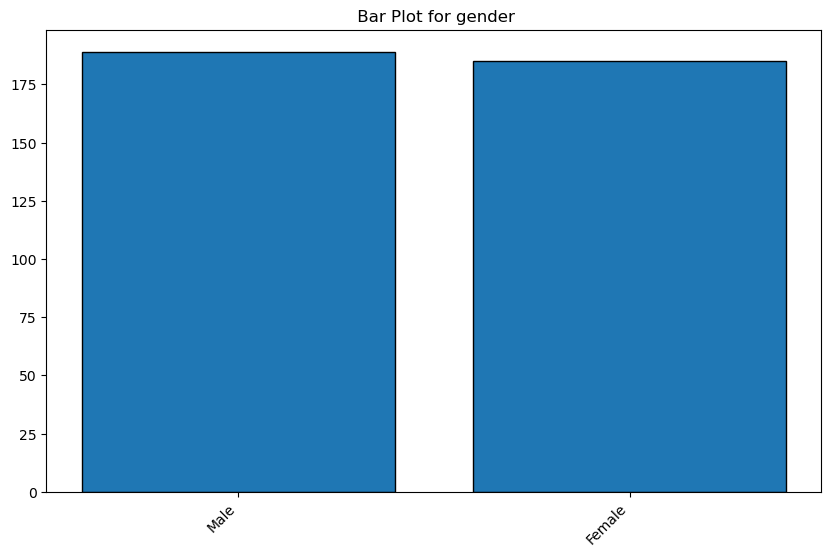

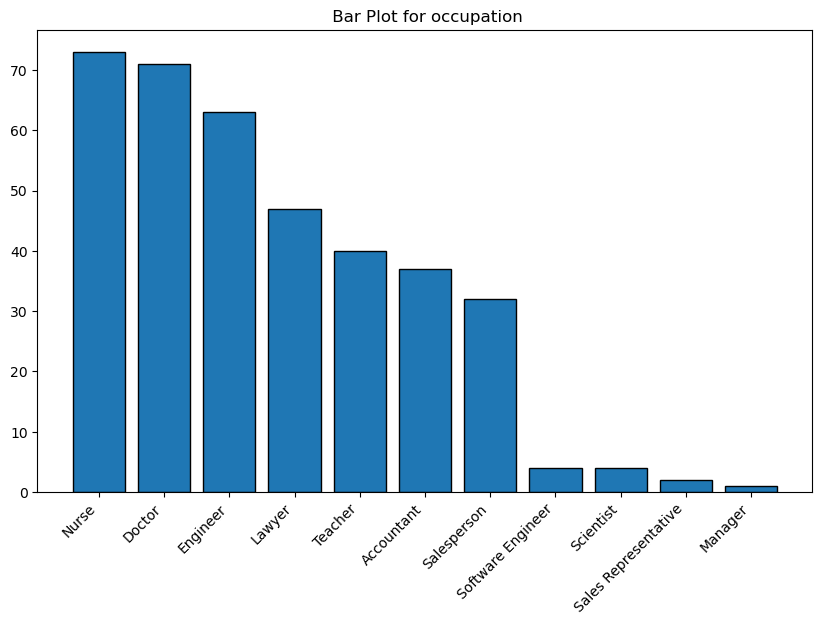

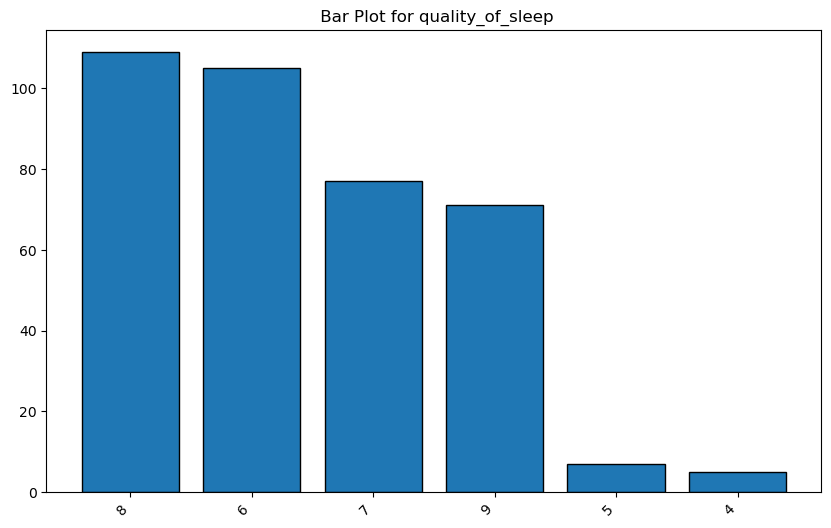

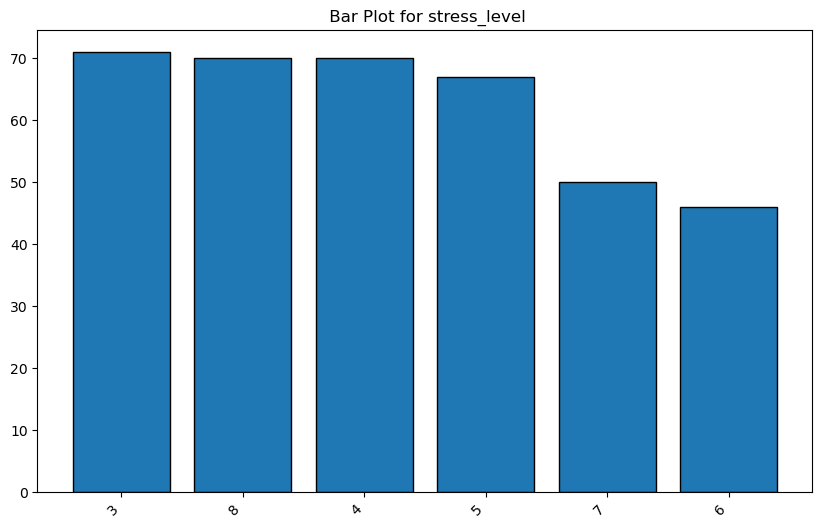

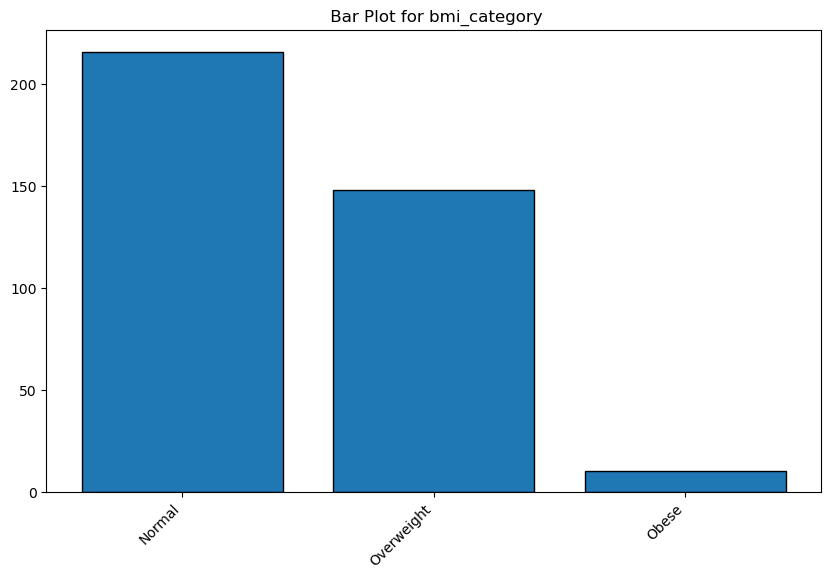

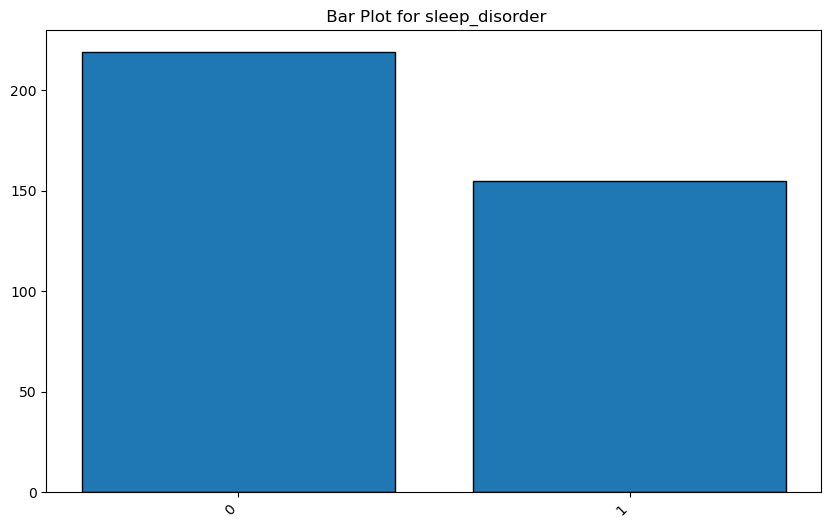

In [8]:
# TODO: Flo - make plots be subplots instead of individual plots

### Categorical Values
print("Categorical Values: ", categorical_variables)

#function to create barplot for each categorical variable
def pie_bar(data, feature):
    fig, axs = plt.subplots(1,1, figsize=(10, 6))
    count_values = data[feature].value_counts()
    axs.bar(height = count_values.values,x = count_values.index,edgecolor= 'black')
    axs.set_xticks(range(len(count_values)))
    axs.set_xticklabels(count_values.index, rotation=45, ha='right')
    axs.set_title(f" Bar Plot for {feature}")
# call function
for cat in categorical_variables:
    pie_bar(data,cat)


Of the seven numerical variables, all are continious. Plotting histograms and boxplots side by side, two categories emerge: 
- measured variables
- estimated/rounded variables (variables that probably where estimated as part of a questioneer by its participants)

For the measured variables age, haert rate and sleep duration, a more or less continious distribution can be identified for age, with while showing variance still is somewhat uniformly distributed in between the limits of around 30 to 60. Furthermore, appears to show three groups with one group having very little sleep (up to 6,5 hours) and one group sleeping for longer times (more than 8 hours) , while in between these two a dip in sleeping time can be observed. As last variable of this group, the heart rate is shown to have the majority of its observations inbetween 65 and 75 with visual hints to a normal distributions, but shows both in histogram and boxplot significant outliers for higher hartrates which will have to be adressed in the preprocessing step. 

The estimated/rounded variables (physical activity level,  daily steps, blood_pressure_systolic/diastolic) shows a specific characteristic with a back and forth between highs and lows which can be attributed to the way people estimate numeric values in increments, like evaluating the physical activity level (mins/day) mostly in increments of 15 min (half an hour, 45 min, one hour, etc.) The lows inbetween then show observations with more specific anwser like 42 min, leading to the somewhat irregular apperance of the histograms. Taking this into account, the phyiscal activity level shows a fairly uniform distribution of observation, while dailty steps tends more into the direction of a right skewed uniform distribution, leading to an overall potentially above average fit sample of people. The high percentage of medical workers with a great walking distances as part of their profession might further contribute to this. Meanwhile, the blood preassure systolic/diastolic appears to both be more or less evenly distributed.

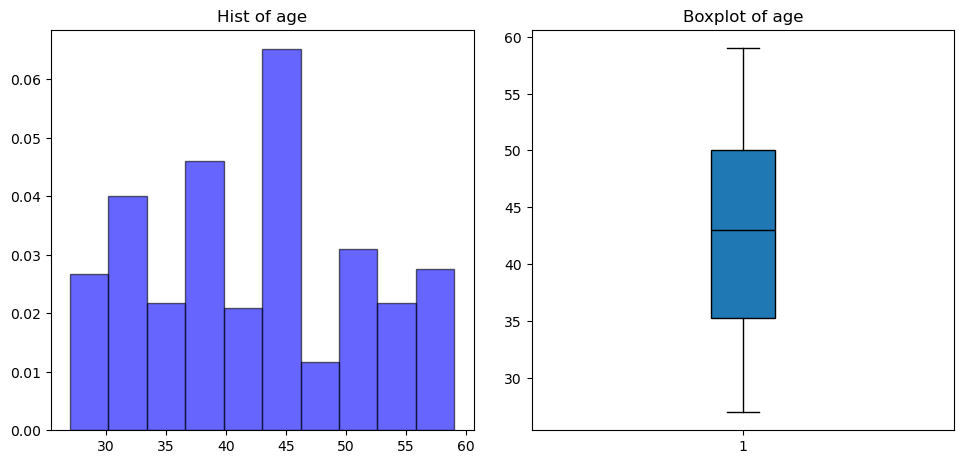

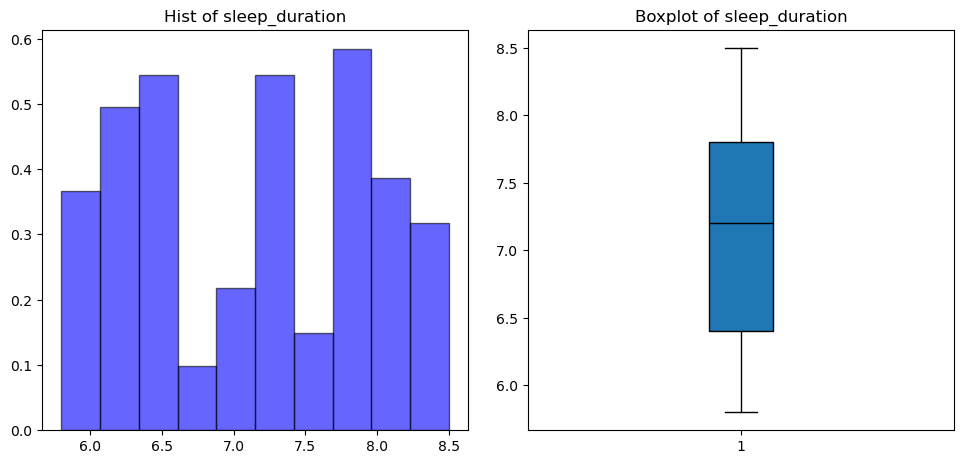

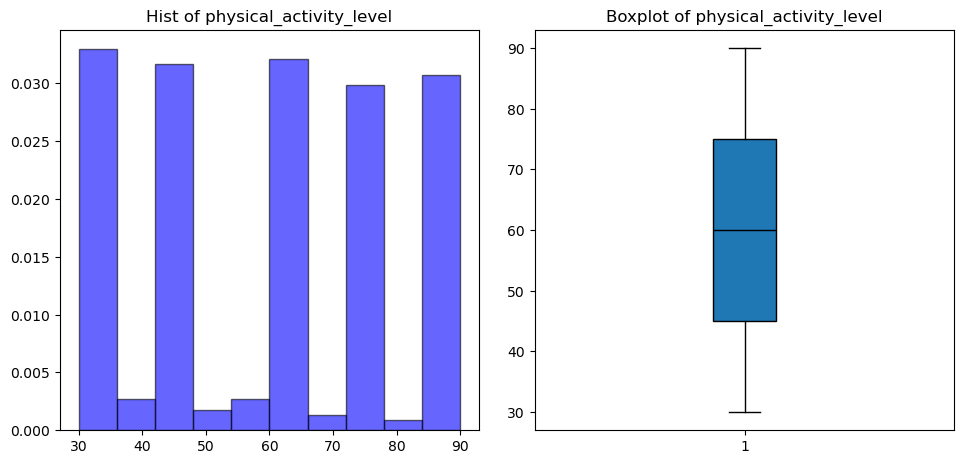

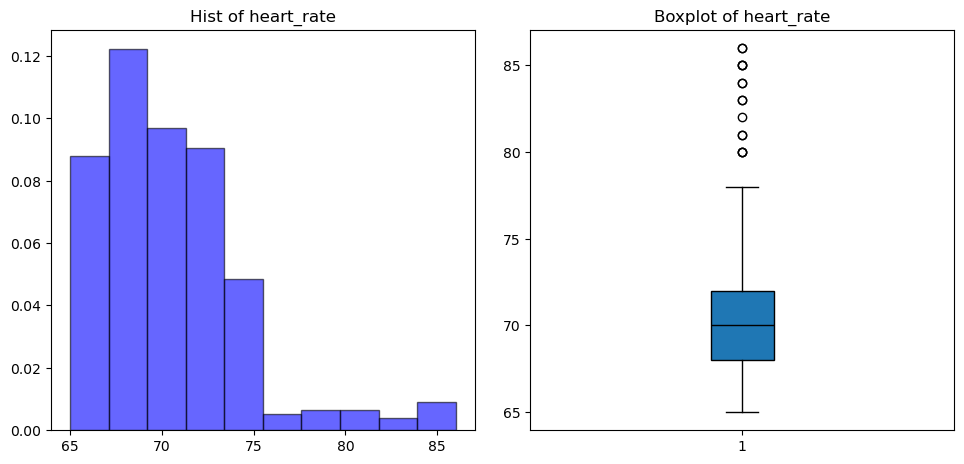

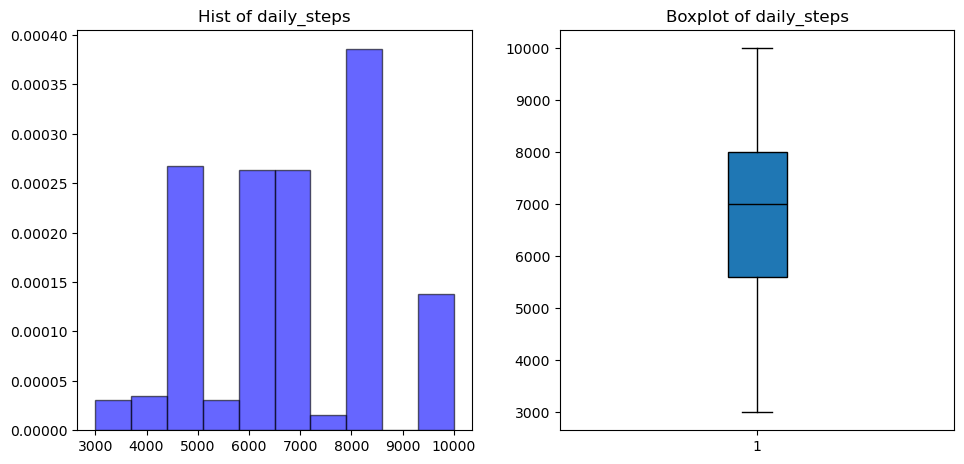

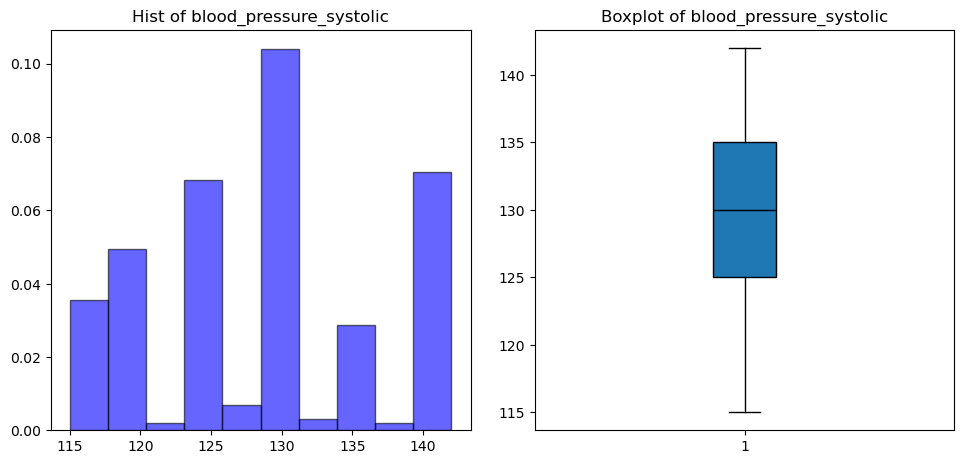

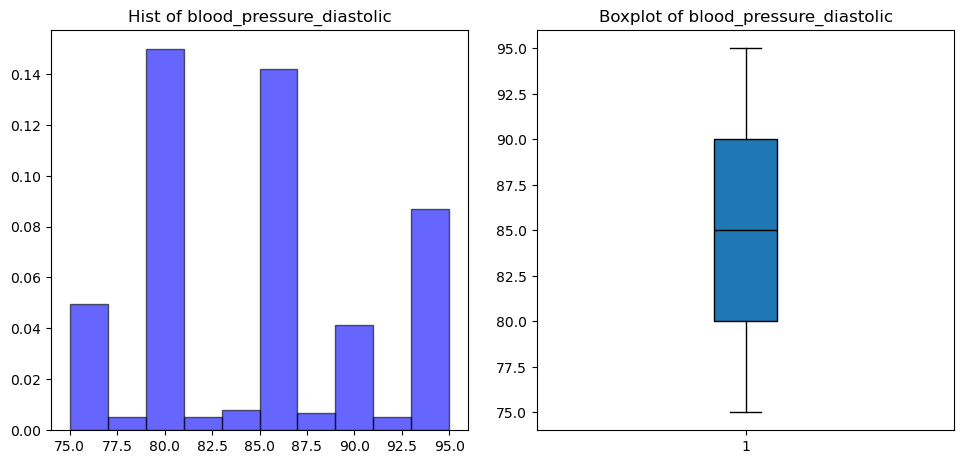

In [9]:
# TODO: Add x axis label, turn into two big plots

# function for histogram + boxplots on numerical variables
def hist_box_plot(data, feature):
    fig, axs = plt.subplots(1,2, figsize=(10, 5))
    axs[0].hist(data[feature],bins=10,density=True,alpha=0.6,color='b',edgecolor="black")
    axs[0].set_title(f"Hist of {feature}")
    axs[1].boxplot(data[feature],vert=True, patch_artist=True,medianprops=dict(color="black"))
    axs[1].set_title(f"Boxplot of {feature}")
    plt.tight_layout(pad=2.0)

# call function
for numeric_variable in numeric_variables:
    hist_box_plot(data,numeric_variable)


As a first attempt to evaluate the correlations found in this dataset, the following set of Metrics is applied and plotted.

$$
q_1 = \left(1 - \frac{\min \lambda_j}{\max \lambda_j} \right)^{p+2}, \quad
$$
$$
q_2 = 1 - \frac{p}{\sum_{j=1}^p (1/\lambda_j)}, \quad
$$
$$
q_3 = 1 - \sqrt{|R|}, \quad
$$
$$
q_4 = \left(\frac{\max \lambda_j}{p} \right)^{3/2}, \quad
$$
$$
q_5 = \left(1 - \frac{\min \lambda_j}{p} \right)^5, \quad
$$
$$
q_6 = \sum_{j=1}^p \frac{1 - 1/r_{ij}}{p}
$$

The resulting plot shows high correlation metric scores for all metric except for metric 4.

[0.948209   0.9115284  0.96033816 0.25164604 0.98831354 0.76247781]


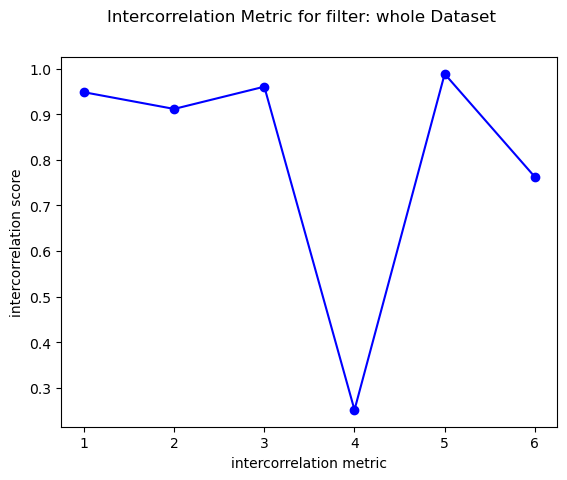

In [10]:
### Statistical Analysis & intercorrelation

means = data[numeric_variables].mean()
variances = data[numeric_variables].var()
df_covariance_matrix = data[numeric_variables].cov()
df_correlation_matrix = data[numeric_variables].corr()

def intercorrelations(X,categorical_filter = "whole Dataset"):
    n, p = X.shape
    R = np.corrcoef(X, rowvar=False)
    lambda_vals, _ = eig(R)
    rjj = np.diag(inv(R))
    q = np.zeros(6)
    q[0] = (1 - min(lambda_vals) / max(lambda_vals)) ** (p + 2)
    q[1] = 1 - p / np.sum(1. / lambda_vals)
    q[2] = 1 - np.sqrt(det(R))
    q[3] = (max(lambda_vals) / p) ** (3 / 2)
    q[4] = (1 - min(lambda_vals) / p) ** 5
    q[5] = np.sum((1 - 1. / rjj) / p)
    
    # print
    print(q)

    # plot
    plt.plot(range(1, 7), q, marker='o', linestyle='-', color='b', label='Intercorrelations')
    plt.xlabel("intercorrelation metric")
    plt.ylabel("intercorrelation score")
    plt.suptitle("Intercorrelation Metric for filter: "+categorical_filter)
    return None


intercorrelations(data[numeric_variables])

Applying the same method to a dataset filtered on the binary variable sleep disorder shows an overall higher than before correlation in the subset for (??????) while the subset for (???????) shows lower correlation metrics than the joined dataset.

[0.89043129 0.85848947 0.9475162  0.19168981 0.97888426 0.75689052]
[0.97710909 0.95408716 0.98689285 0.37193839 0.99337259 0.88299737]


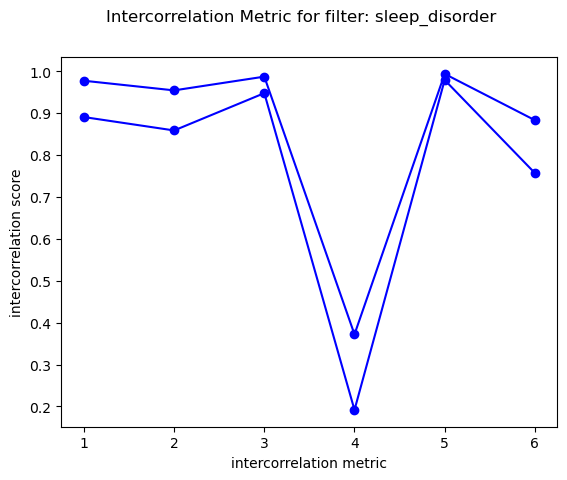

In [11]:
# TODO: Color the two plots by category

#intercorrelation by category function
def inter_by_category(df,cat):
    count_values = df[cat].value_counts().index
    for i in count_values:
        aux_data = df[df[cat]==i]
        intercorrelations(aux_data[numeric_variables],categorical_filter=cat)

inter_by_category(data,'sleep_disorder')

# inter_by_category(data,'stress_level')
# inter_by_category(data,'stress_level')
# inter_by_category(data,'bmi_category')
# inter_by_category(data,'sleep_disorder')
# inter_by_category(data,'quality_of_sleep')

Expandning the coreelation analysis with a paiplot shows a veriaty of potential correlations between variables, the most notable being between the linear correlation betwen blood pressure systolic and diastolic as well as between daily steps and heart rate/ blood pressure. Further correlation can bee seen inbetween physical activity level and sleep duration while the plot age vs sleep duration appears to show certain clusters that may be further analyzed in the second part of this work. 

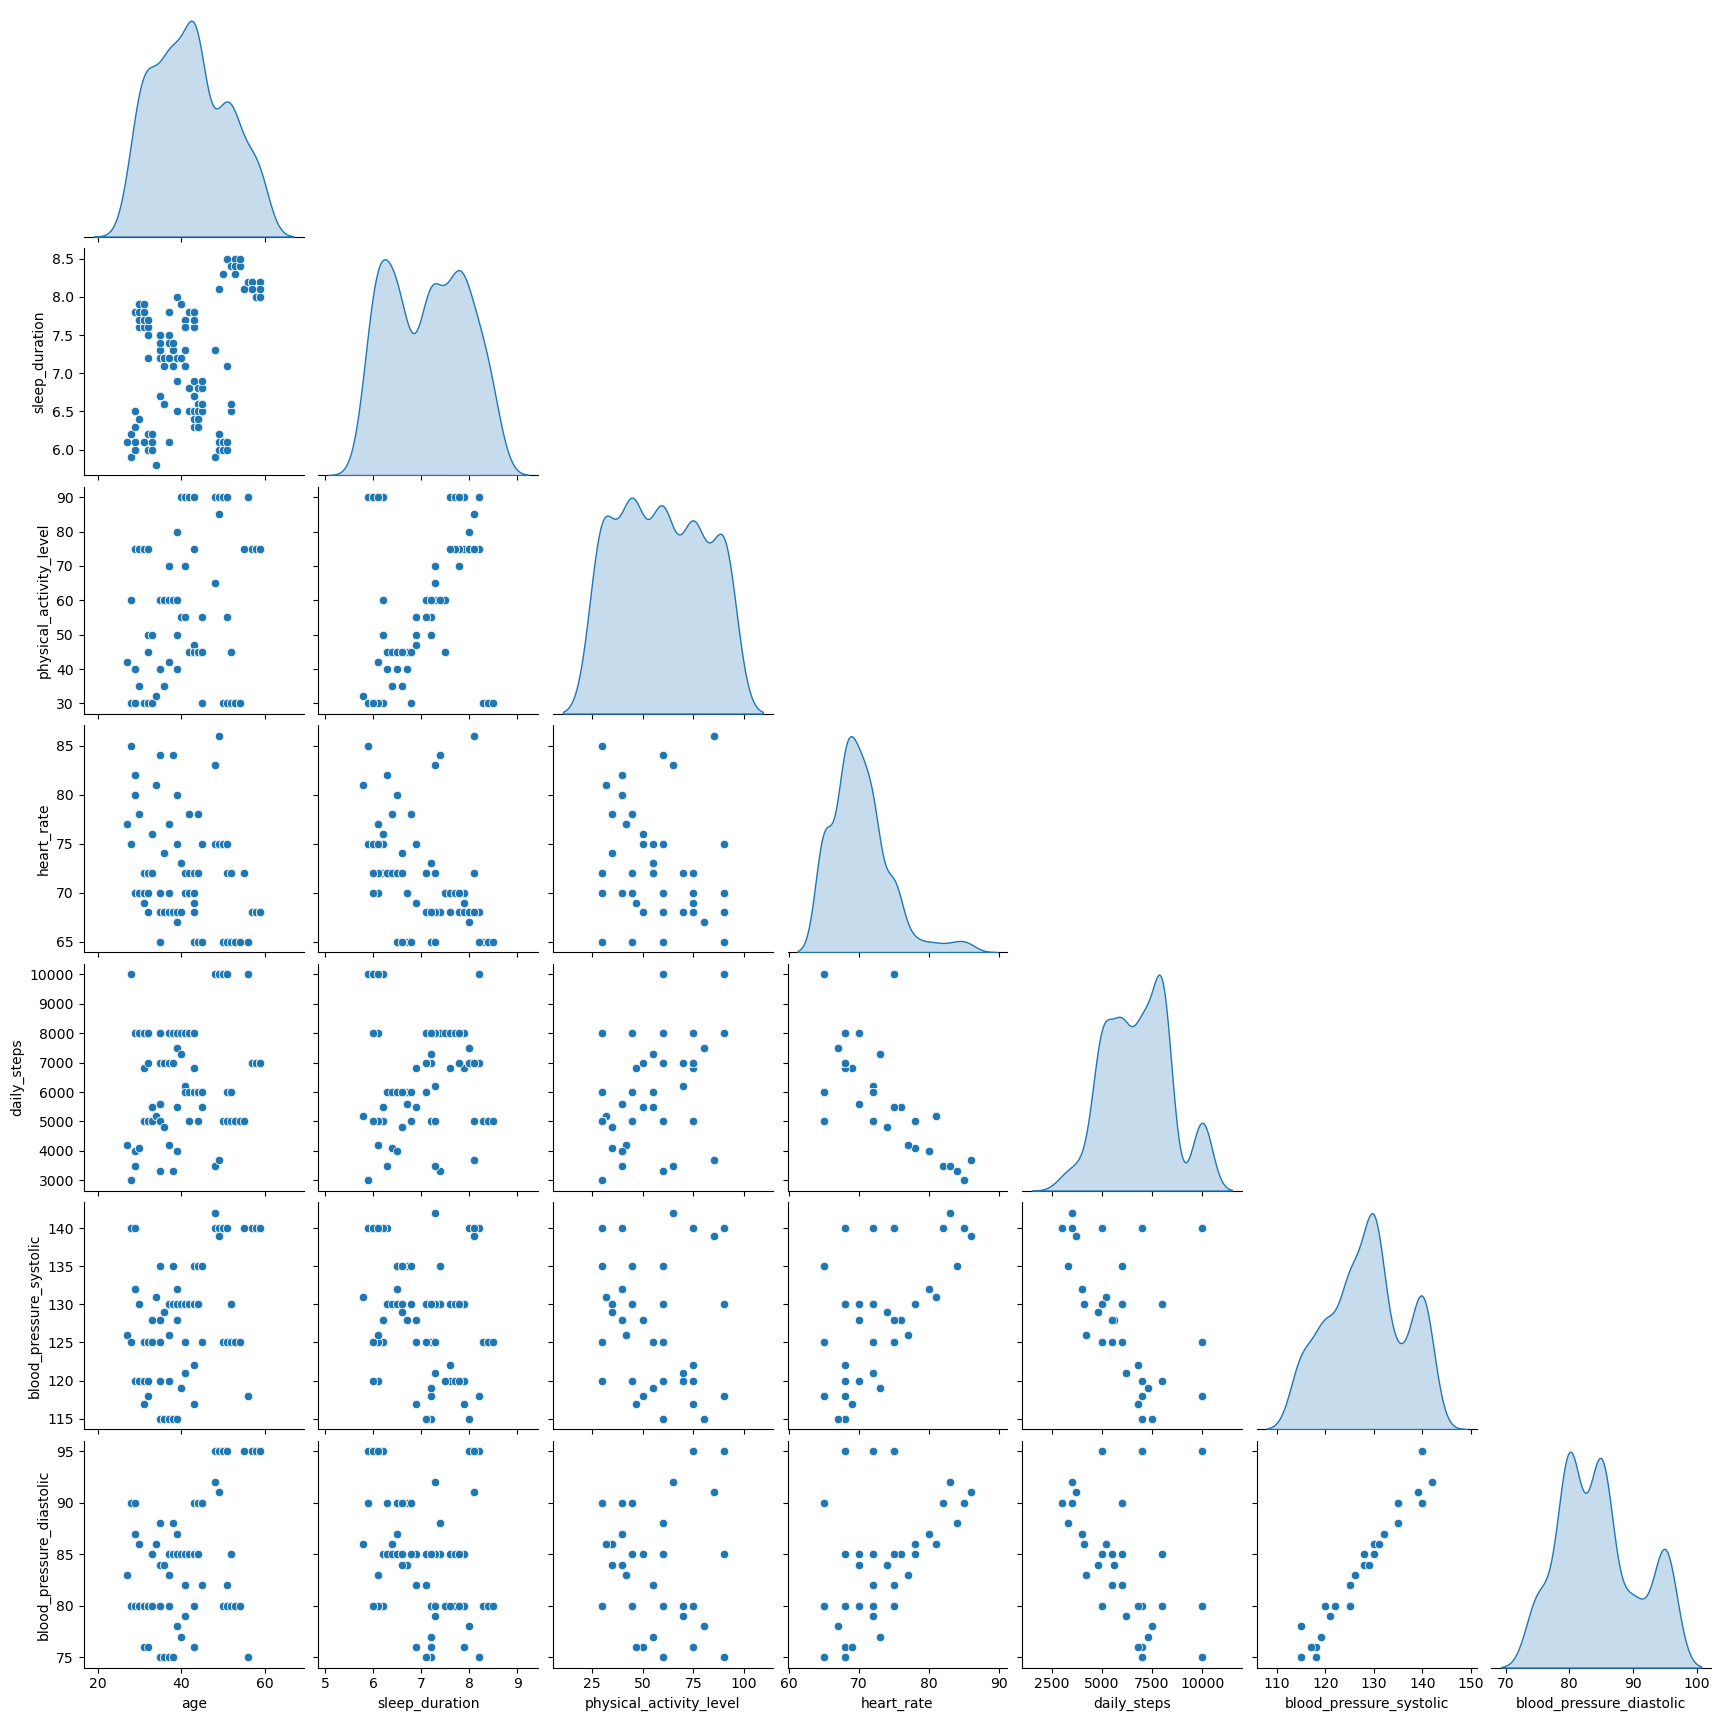

In [12]:
# pairplot
sns.pairplot(data[numeric_variables], diag_kind='kde', corner=True)
plt.show()

Plotting the correlation corresponding matrix reflects some of the observations made in the pairplot, with the verious near 100% correlation between blood pressure systolic and diastolic very aparent. Two previously less apparent correlations are the ones between age and blood pressure as well as the correlation between physical activity and daily steps. 

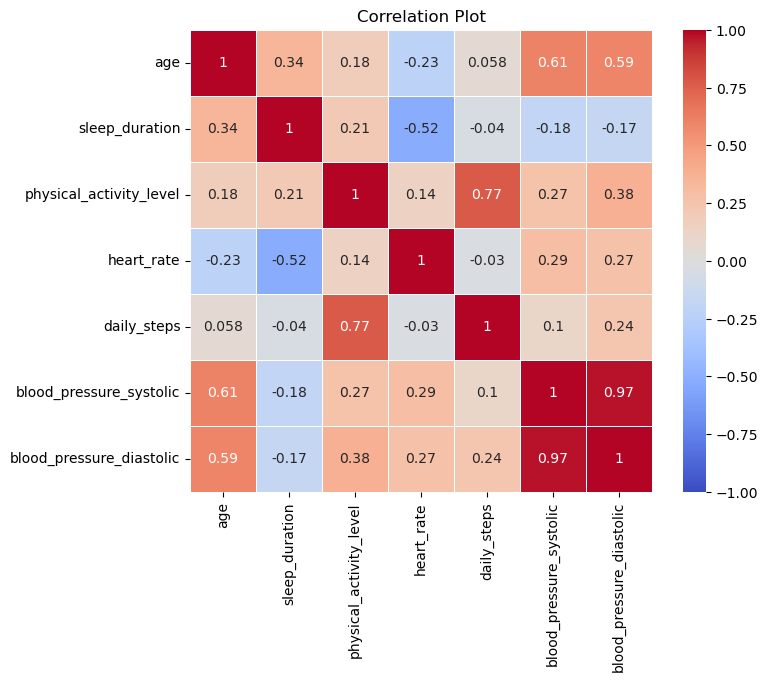

In [13]:
corr_mat = data[numeric_variables].corr()
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

Plotting the covariance matrix however shows an issue with the current format of the data, where daily steps outweighs all other variances due to its scale (3000 - 10000). This issue will be adressed in the next section of part one of this work. 

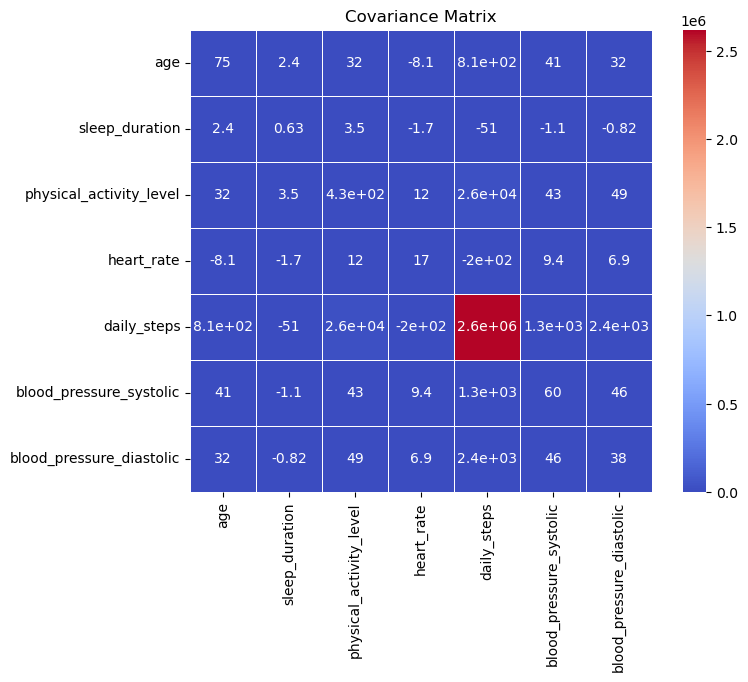

In [14]:
def cov_plot(data,numeric_variables):
    corr_mat = data[numeric_variables].cov()
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', square=True, linewidths=0.5)
    plt.title('Covariance Matrix')
    plt.show()

cov_plot(data,numeric_variables)

Having a general overview of structure and correlation in the data, the next step is to scaling and outlier issues in the next subsection.

In [15]:
# # Function for plotting of conditional histograms 
# def plot_categorical_hist(data,
#                           ncols,
#                           numeric_variables,
#                           categorical_variables,
#                           host_stat='count',
#                           figsize=(12, 10)
#                           ):
    
#     nrows = math.ceil(len(numeric_variables)/ncols)
#     fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
#     for i, col in enumerate(numeric_variables):
#         row = i // 2 
#         col_pos = i % 2 
#         sns.histplot(data=data, x=col, bins=10,hue=categorical_variables, kde=True, ax=axes[row, col_pos],stat=host_stat)
#         axes[row, col_pos].set_title(f'Distribution of {col}')

#     # Adjust layout for better spacing
#     plt.tight_layout()
#     plt.show()

# # TODO: Select relevant ones 
# for categorical_variable in categorical_variables:
#     print(categorical_variable)
#     plot_categorical_hist(data=data,
#                           ncols=2,
#                           numeric_variables=numeric_variables,
#                           categorical_variables=categorical_variable,
#                           host_stat='probability',
#                           figsize=(12, 20))

# Preprocessing

The following two issues in the current data set: 
- Outliers in variable "heart rate"
- Scaling issue to (among others) variable "daily steps"

This section corrects outliers, validates skewness and standardizes the numeric variables.

## Outliers and Skewness

The aim of this part of the preprocessing, is to obtain symmetric variables without outliers in order to apply in a correct form the PCA. 

It is observed that only one variable has outliers and positive skewness problems (heart rate). Therefore, the first step is to cut the outliers (4% of the dataframe), and then, check if the skewness problem is also corrected.

In [16]:
# print skewness
for i in numeric_variables:
    aux_skew = stats.skew(data[i])
    print(f"Skewness of {i} : {aux_skew}")

Skewness of age : 0.2561893511793312
Skewness of sleep_duration : 0.037403602518975176
Skewness of physical_activity_level : 0.07418782500797434
Skewness of heart_rate : 1.2199056700731632
Skewness of daily_steps : 0.17756151681455
Skewness of blood_pressure_systolic : -0.03552565092220491
Skewness of blood_pressure_diastolic : 0.37705009626387237


In [17]:
summary_stats = []

for i in numeric_variables:
    # Compute the descriptive statistics using scipy.stats.describe
    description = stats.describe(data[i])
    p90 = np.percentile(data[i], 90)
    p95 = np.percentile(data[i], 95)
    p99 = np.percentile(data[i], 99)

    # Store the results as a dictionary (with variable name as key)
    summary_stats.append({
        'Variable': i,
        'Count': description.nobs,
        'Min': description.minmax[0],
        'Mean': description.mean,
        'Percentile 90%': p90,
        'Percentile 95%': p95,
        'Percentile 99%': p99,
        'Max': description.minmax[1],
        'Variance': description.variance
    })

# Convert the list of dictionaries to a DataFrame for easier display
summary_df = pd.DataFrame(summary_stats)

# Display the summary statistics table
print(summary_df)


                   Variable  Count     Min         Mean  Percentile 90%  \
0                       age    374    27.0    42.184492            54.0   
1            sleep_duration    374     5.8     7.132086             8.2   
2   physical_activity_level    374    30.0    59.171123            90.0   
3                heart_rate    374    65.0    70.165775            75.0   
4               daily_steps    374  3000.0  6816.844920          8000.0   
5   blood_pressure_systolic    374   115.0   128.553476           140.0   
6  blood_pressure_diastolic    374    75.0    84.649733            95.0   

   Percentile 95%  Percentile 99%      Max      Variance  
0            58.0            59.0     59.0  7.522324e+01  
1             8.4             8.5      8.5  6.330696e-01  
2            90.0            90.0     90.0  4.339224e+02  
3            78.0            85.0     86.0  1.710381e+01  
4         10000.0         10000.0  10000.0  2.617651e+06  
5           140.0           140.0    142.0  6

In [18]:
for i in numeric_variables:
    q1 = np.percentile(data[i], 25)
    q3 = np.percentile(data[i], 75)
    RIC = q3 - q1 
    nout = np.sum(data[i] > (q3 + 1.5*RIC))
    print(f"The threshold for {i} upper outliers is  {q3 + 1.5*RIC}")
    print(f" then there are {nout} outliers in this variable, representing the {np.round(nout/374*100,2)} % of the dataset")

The threshold for age upper outliers is  72.125
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for sleep_duration upper outliers is  9.899999999999999
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for physical_activity_level upper outliers is  120.0
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for heart_rate upper outliers is  78.0
 then there are 15 outliers in this variable, representing the 4.01 % of the dataset
The threshold for daily_steps upper outliers is  11600.0
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for blood_pressure_systolic upper outliers is  150.0
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for blood_pressure_diastolic upper outliers is  105.0
 then there are 0 outliers in this variable, representing the 0.0 % of

We can see that the skewness was also corrected by cutting the oultiers observations. For that reason, there is not needed another type of transformation.

Skewness of heart_rate : 0.207482395234077


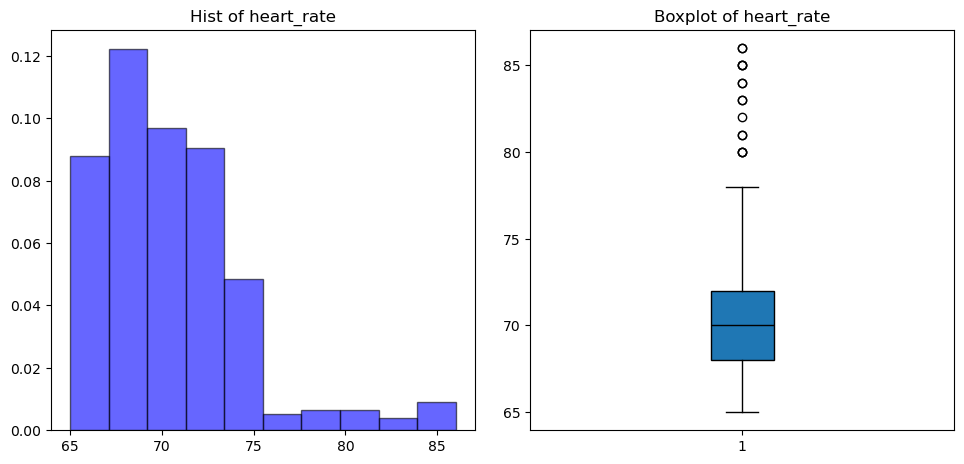

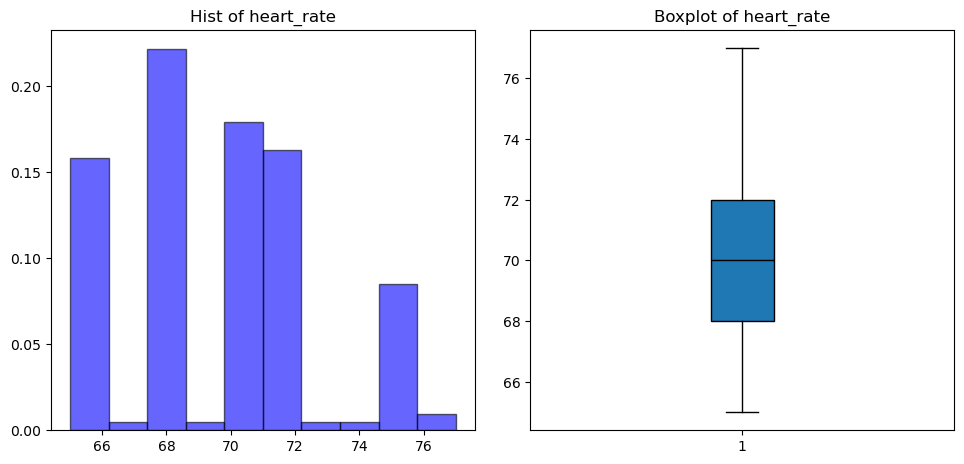

In [25]:
# temporary data while we have all the transformations
data_cut = data[data['heart_rate'] < 78] 

# CHECKING SKEWNESS AFTER CUTTING OUTLIERS
aux_skew = stats.skew(data_cut["heart_rate"])
print(f"Skewness of heart_rate : {aux_skew}")

# plot hist % boxplot before and after
hist_box_plot(data,"heart_rate")
hist_box_plot(data_cut,"heart_rate")

## Standardize numeric variables

Having seen in the exploratory data analysis that there exists a strong imbalance in scale between numerical variables in the dataset, the dataset is standardized in this step to mean 0 and scaled on its standarddeviation.

In [20]:
# scale
data_standardized_numeric = (data_cut[numeric_variables] - data_cut[numeric_variables].mean()) / data_cut[numeric_variables].std()
data_standardized = pd.concat([data_standardized_numeric,data_cut[categorical_variables]], axis =1)


Comparing the boxplots pre-standardized and post-standardized shows the major impact the rescaling has, where daily steps previously dominated and now an even distribution for all numeric variables can be seen.

Text(0.5, 0.98, 'Boxplots not-standardized vs standardized')

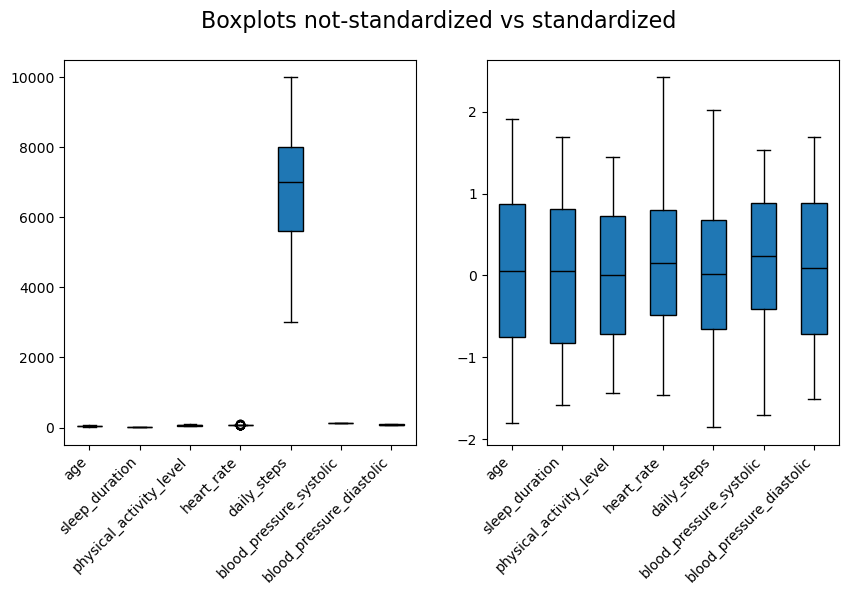

In [21]:
# plot
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs[0].boxplot(data[numeric_variables],vert=True, patch_artist=True,medianprops=dict(color="black"))
axs[0].set_xticklabels(numeric_variables, rotation=45, ha="right")
axs[1].boxplot(data_standardized_numeric[numeric_variables],vert=True, patch_artist=True,medianprops=dict(color="black"))
axs[1].set_xticklabels(numeric_variables, rotation=45, ha="right")
fig.suptitle("Boxplots not-standardized vs standardized", fontsize=16)

As a result from scaling, now the covariance matrix can be constructed, showing similar results compared to the previously analyzed correlation matrix. 

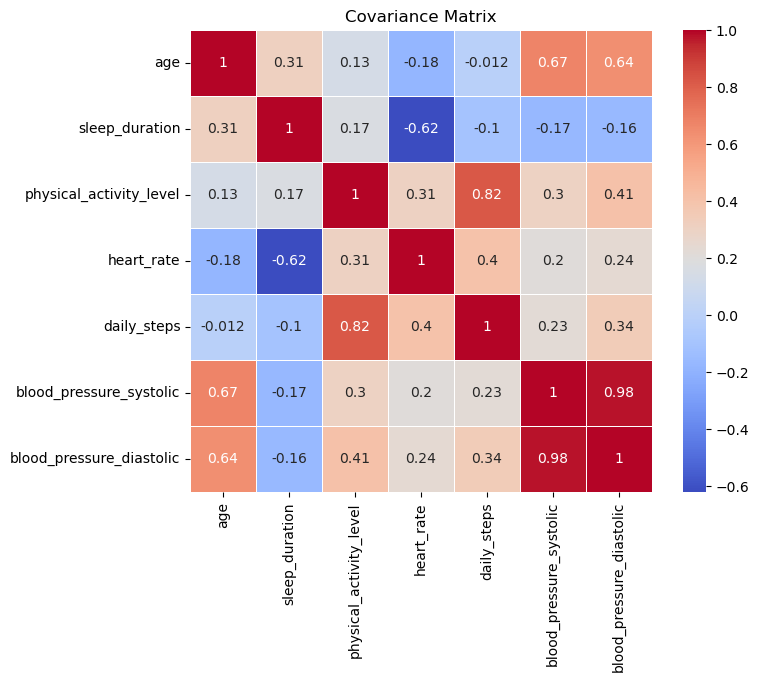

In [22]:
cov_plot(data_standardized,numeric_variables)

## PCA

Having analyzed the data and its characteristic and highly correlated variables identified, as well as having eliminated outliers as well as having standardized the numeric variables, principal component analysis can now be applied in an attempt to reduce dimensionality. 

In [87]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [103]:
data_pca = data_standardized[numeric_variables]
pca = PCA()
pca.fit(data_pca)

PCA()

In [108]:
eig_val = pca.explained_variance_
print("Explained Variance: ", eig_val)

sv = pca.singular_values_
print("Singular Values: ", sv)

#----------------------- JUST CHECKING MATHS -----------------------
singular_values_squared = sv ** 2
# Compare singular values squared vs eigenvalues
normalized_singular_values_squared = singular_values_squared / (X_scaled.shape[0] - 1)
print("Eigenvalues (Explained Variance):", eig_val)
print("Singular Values Squared (Normalized):", normalized_singular_values_squared)
#--------------------------------------------------------------------------------

# Covariance Matrix
S = np.cov(data_pca, rowvar=False)
print("trace: ", S.trace())

# Kaiser´s criterion
mean_eig = S.trace()/7

# Jollife´s criterion
joliffe = 0.7 * S.trace()/7

Explained Variance:  [2.98968211 1.91745272 1.4083181  0.35319134 0.21650964 0.09865361
 0.0161925 ]
Singular Values:  [32.4862707  26.01654875 22.29655327 11.16586514  8.74230527  5.90124756
  2.39080551]
Eigenvalues (Explained Variance): [2.98968211 1.91745272 1.4083181  0.35319134 0.21650964 0.09865361
 0.0161925 ]
Singular Values Squared (Normalized): [2.98968211 1.91745272 1.4083181  0.35319134 0.21650964 0.09865361
 0.0161925 ]
trace:  7.000000000000006


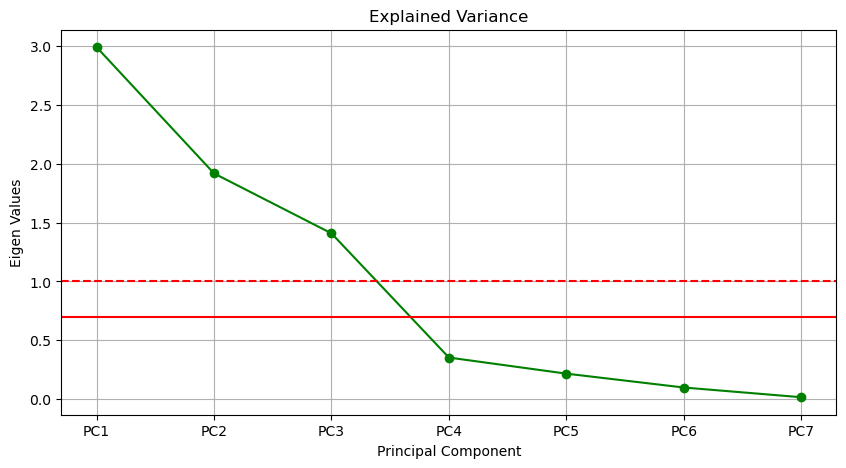

In [109]:

plt.figure(figsize=(10, 5))
plt.plot(eig_val, marker = 'o', linestyle = '-', color = 'g')
plt.axhline(y=mean_eig, color='r', linestyle='--', label='Keisers Criterion')
plt.axhline(y=joliffe, color='r', linestyle='-', label='Jollife Criterion')
plt.title("Explained Variance")
plt.xlabel("Principal Component")
plt.ylabel("Eigen Values")

# Change xlabels
tick_positions = [0, 1, 2, 3, 4, 5, 6]
custom_labels = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']  

# Set custom x-ticks with custom labels
plt.xticks(ticks=tick_positions, labels=custom_labels)

plt.grid(True)
plt.show()

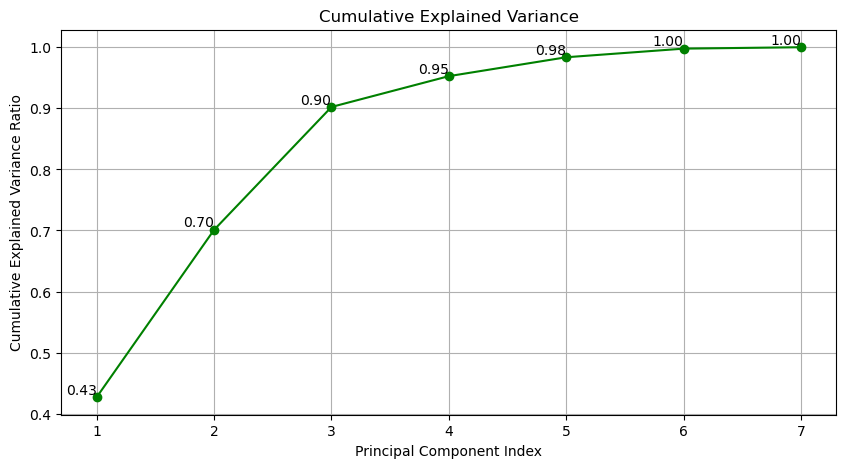

In [78]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Show the cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='g')
plt.title("Cumulative Explained Variance")
plt.xlabel("Principal Component Index")
plt.ylabel("Cumulative Explained Variance Ratio")

# Adding labels next to the points
for i, (x, y) in enumerate(zip(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)):
    plt.text(x, y, f'{y:.2f}', horizontalalignment='right', verticalalignment='bottom', fontsize=10)

plt.grid(True)
plt.show()
